https://www.nature.com/articles/s41586-020-2734-6

In [1]:
data= '../data'
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sn
import scipy.cluster.hierarchy as spc
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [81]:
!wget -P {data} -nc http://files.ddnetbio.com/hrpiFiles/hrpiSN_matrix.mtx.gz
!wget -P {data} -nc http://files.ddnetbio.com/hrpiFiles/hrpiSN_features.tsv.gz
!wget -P {data} -nc http://files.ddnetbio.com/hrpiFiles/hrpiSN_barcodes.tsv.gz
!wget -P {data} -nc http://files.ddnetbio.com/hrpiFiles/hrpiSC_matrix.mtx.gz
!wget -P {data} -nc http://files.ddnetbio.com/hrpiFiles/hrpiSC_features.tsv.gz
!wget -P {data} -nc http://files.ddnetbio.com/hrpiFiles/hrpiSC_barcodes.tsv.gz

File ‘../data/hrpiSN_matrix.mtx.gz’ already there; not retrieving.

File ‘../data/hrpiSN_features.tsv.gz’ already there; not retrieving.

File ‘../data/hrpiSN_barcodes.tsv.gz’ already there; not retrieving.

File ‘../data/hrpiSC_matrix.mtx.gz’ already there; not retrieving.

File ‘../data/hrpiSC_features.tsv.gz’ already there; not retrieving.

File ‘../data/hrpiSC_barcodes.tsv.gz’ already there; not retrieving.



In [82]:
adata=sc.read_10x_mtx(data,cache=True,prefix='hrpiSC_')
adata

AnnData object with n_obs × n_vars = 7194 × 12246
    var: 'gene_ids', 'feature_types'

In [83]:
sc.pp.normalize_total(adata, target_sum=1e5)

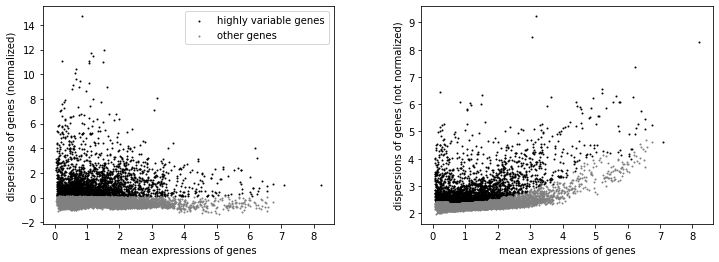

In [84]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10, min_disp=0.1)
sc.pl.highly_variable_genes(adata)

In [85]:
adata.raw = adata

In [86]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 7194 × 3104
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [87]:
df=adata.to_df()
df.shape

(7194, 3104)

In [88]:
tf=pd.read_csv('http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt',index_col=0,header=None)
mir=df.columns[df.columns.str.startswith('MIR')]
df=df.loc[:,df.columns.intersection(tf.index.append(mir))]
df.shape

(7194, 290)

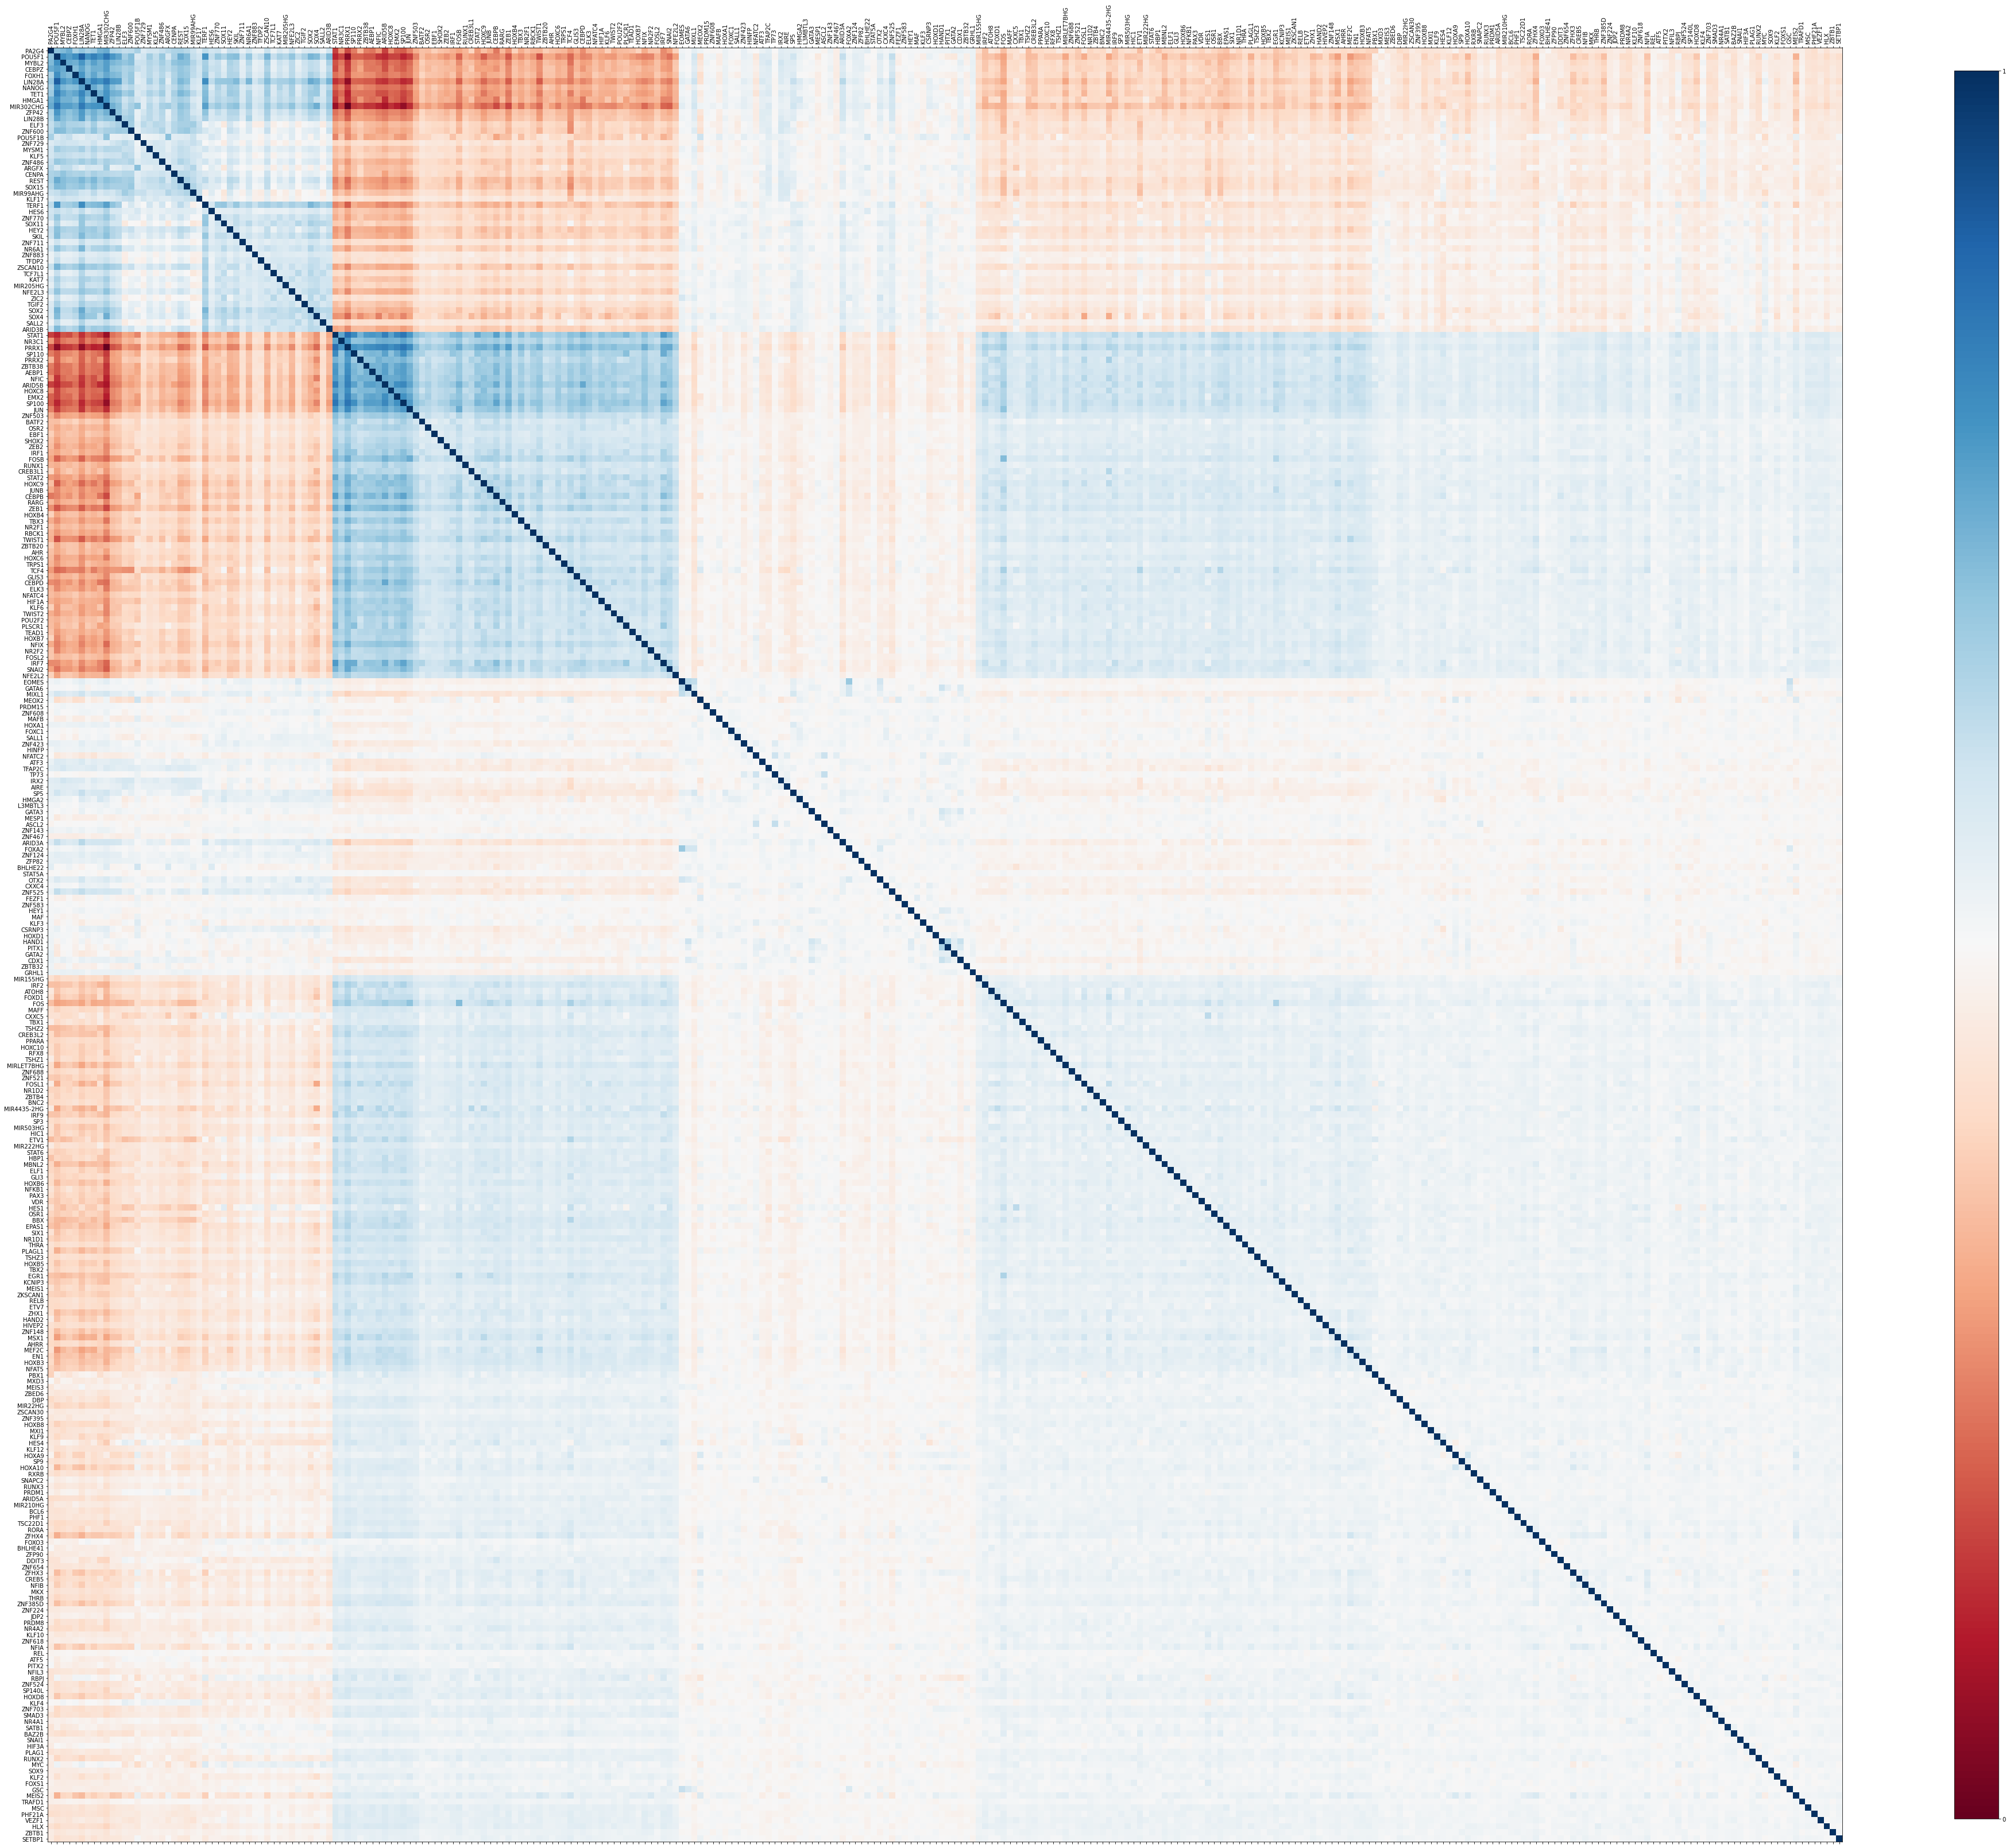

In [89]:
corr= df.corr()
offset = mcolors.TwoSlopeNorm(vmin=corr.min().min(),vcenter=0., vmax=1)
X =corr.values
d = spc.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = spc.linkage(d, method='ward')
ind = spc.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)
size=70
fig, ax = plt.subplots(figsize=(size, size))
corr=corr[df.columns].loc[df.columns]
cax = ax.matshow(offset(corr), cmap='RdBu')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
plt.yticks(range(len(corr.columns)), corr.columns);

# Add the colorbar legend
cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [72]:
adata = sc.AnnData(df.T)
adata

AnnData object with n_obs × n_vars = 290 × 7194

In [10]:
yam=['POU5F1','SOX2','NANOG','KLF4','MYC','LIN28A','LIN28B','MIR302CHG']
adata.obs['yam']=adata.obs.index
adata.obs.loc[~adata.obs['yam'].isin(yam),'yam']='others'

In [11]:
sc.tl.pca(adata, svd_solver='arpack')

In [12]:
sc.set_figure_params(figsize=(20,20))

... storing 'yam' as categorical


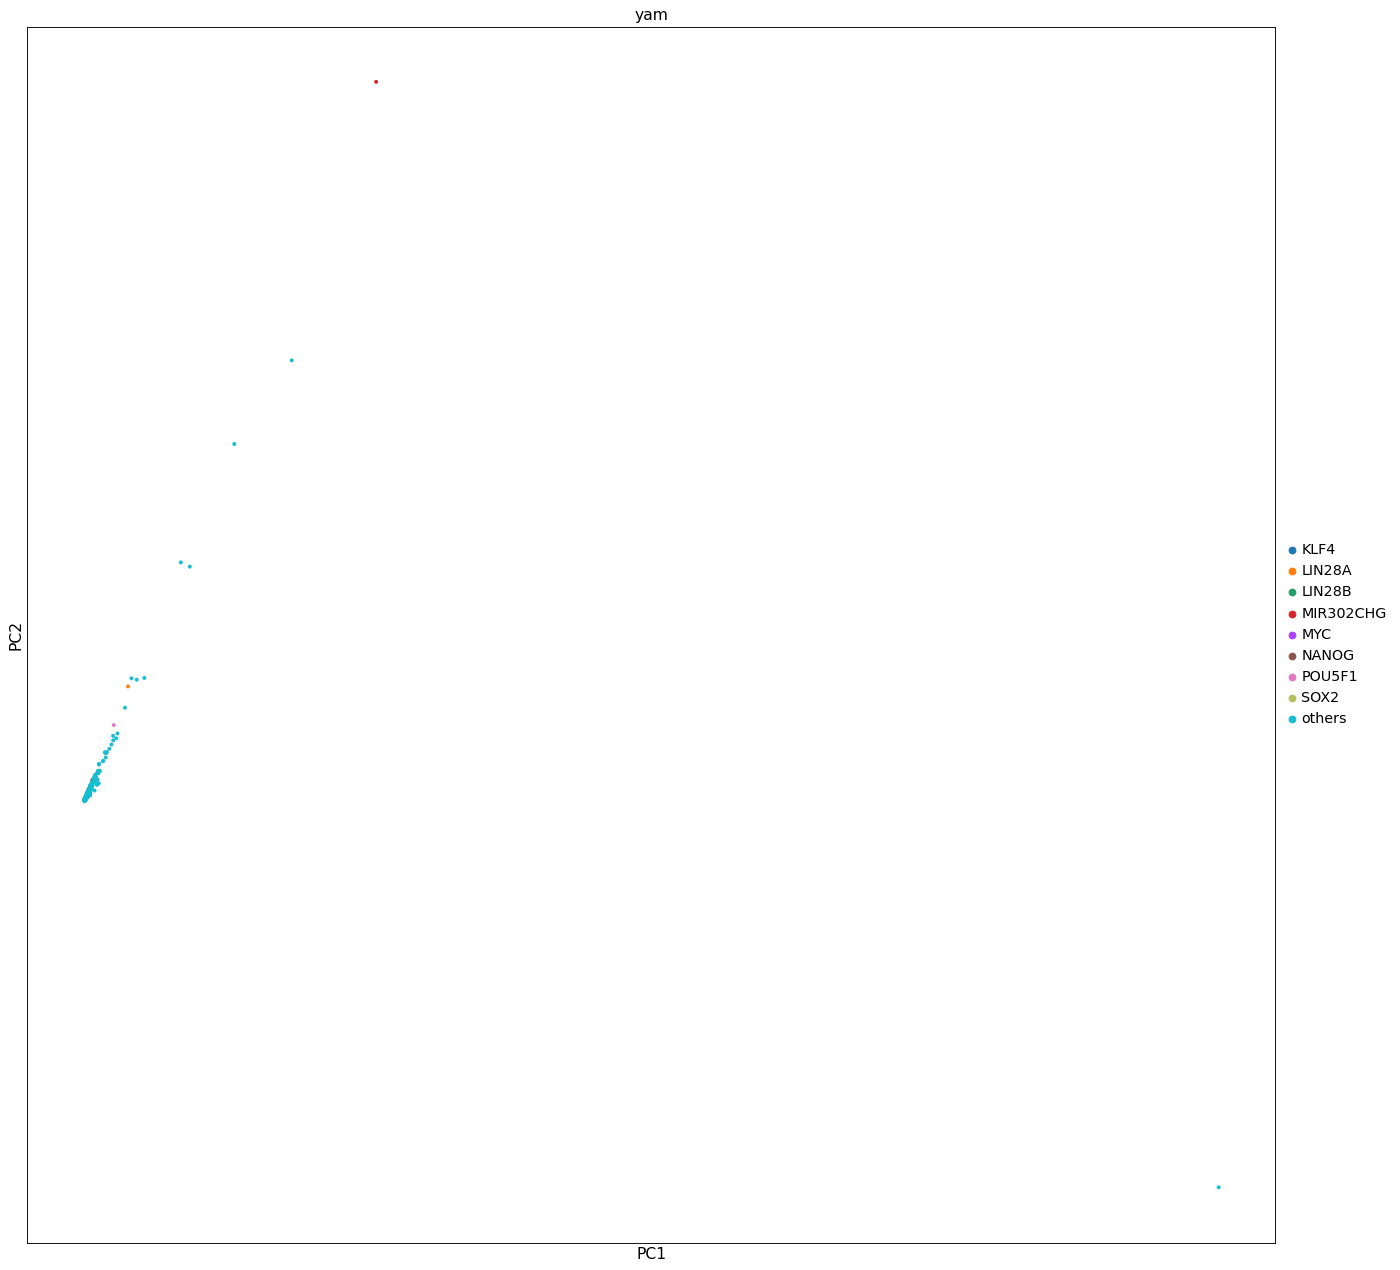

In [13]:
sc.pl.pca(adata,color='yam',size=50)

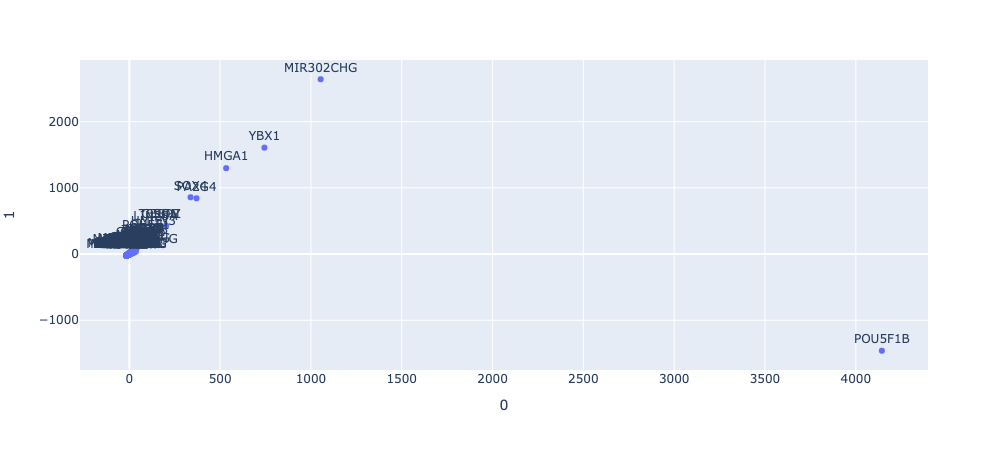

In [16]:
pc=pd.DataFrame(adata.obsm['X_pca'])[[0,1]]
pc.index=adata.obs.index
fig = px.scatter(pc,x=0,y=1,text=pc.index)
fig.update_traces(textposition='top center')
fig.show()

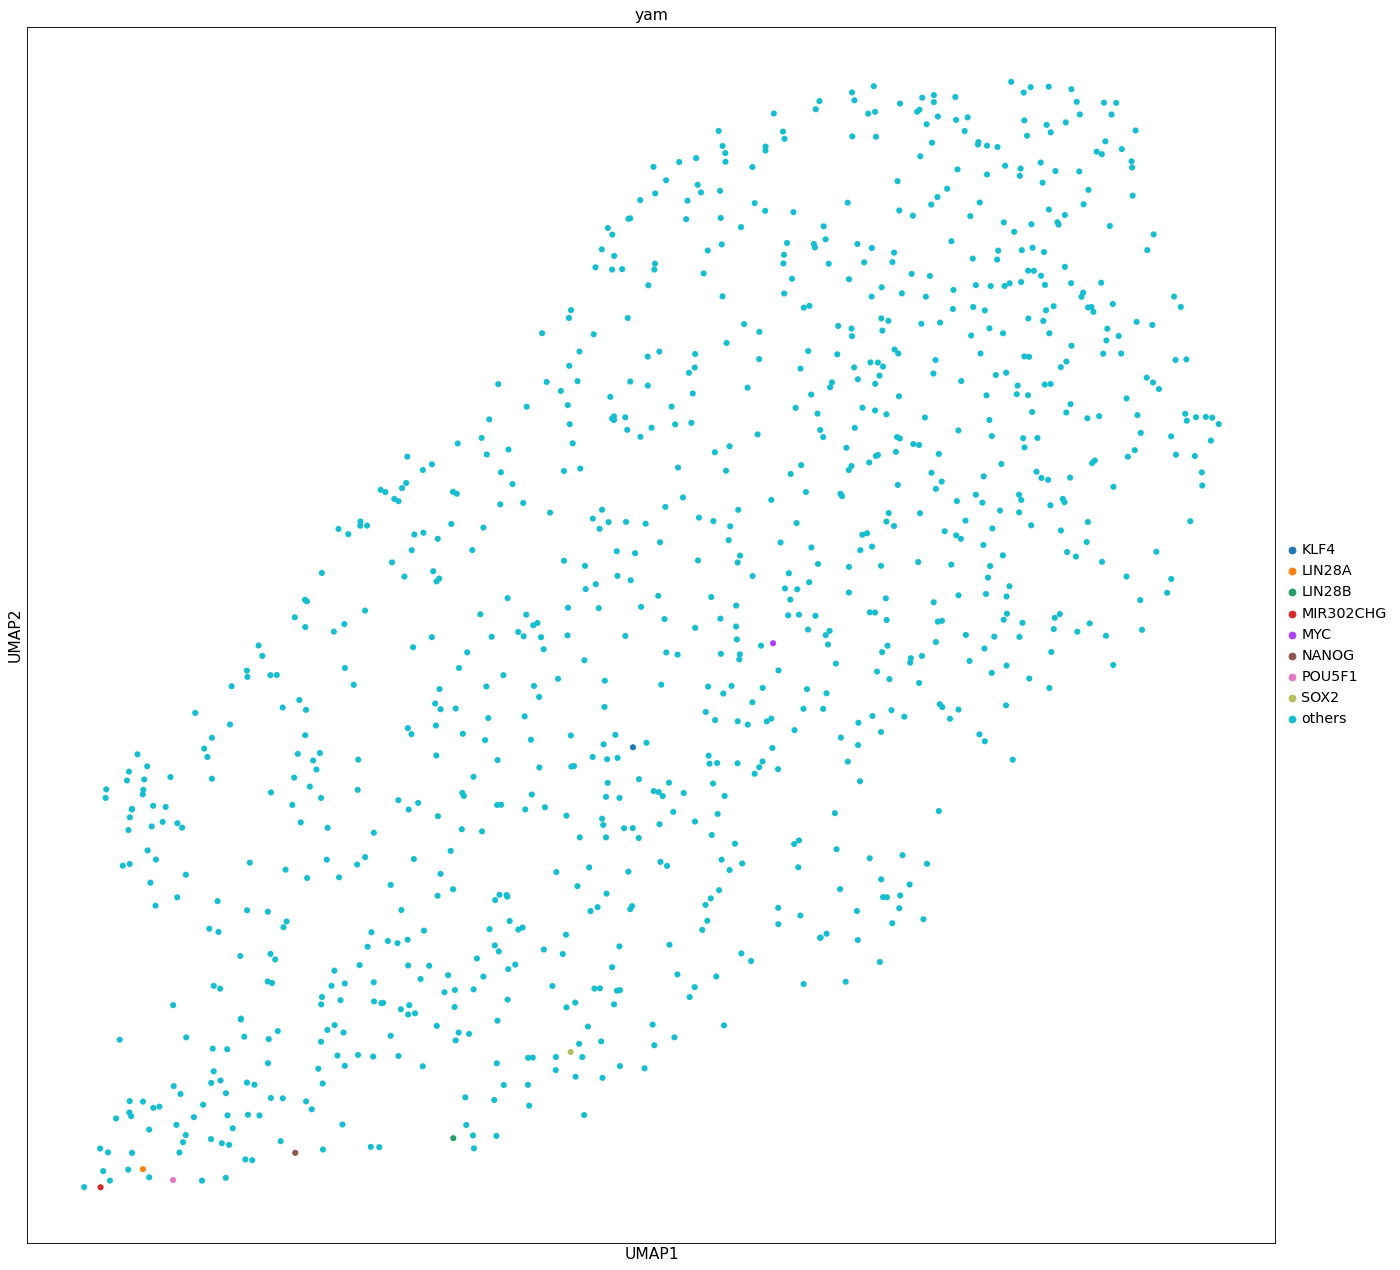

In [17]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='yam')